<a href="https://colab.research.google.com/github/anmoladh/git/blob/master/randomforest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Basic libraries for data manipulation and exploration
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Random Forest Classifier and model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Warnings filter
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully.")


All libraries imported successfully.


In [6]:
# Load the dataset
data = pd.read_csv('/content/synthetic_smart_tv_attack_dataset.csv')

# Display the first few rows
data.head()

# Display information about the dataset
data.info()

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Display descriptive statistics
data.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7581 entries, 0 to 7580
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   timestamp          7581 non-null   object 
 1   source_ip          7581 non-null   object 
 2   destination_ip     7581 non-null   object 
 3   source_port        7581 non-null   int64  
 4   destination_port   7581 non-null   int64  
 5   protocol           7581 non-null   object 
 6   packet_size        7581 non-null   int64  
 7   duration           7581 non-null   float64
 8   num_packets        7581 non-null   int64  
 9   num_bytes          7581 non-null   int64  
 10  response_time      7581 non-null   float64
 11  anomaly_score      7581 non-null   float64
 12  connection_state   7581 non-null   object 
 13  dns_requests       7581 non-null   int64  
 14  http_requests      7581 non-null   int64  
 15  data_exfiltration  7581 non-null   int64  
 16  attack_type        7581 

source_port  destination_port  packet_size     duration  num_packets  \
count   7581.000000       7581.000000  7581.000000  7581.000000  7581.000000   
mean   33591.350877       1799.486743   779.041156   150.219836   524.447962   
std    18411.980373       3221.322572   413.878976    86.635056   273.237003   
min     1048.000000         22.000000    64.000000     1.013675    50.000000   
25%    18009.000000         53.000000   421.000000    75.471663   287.000000   
50%    33679.000000         80.000000   776.000000   150.183379   527.000000   
75%    49449.000000        443.000000  1133.000000   224.988560   754.000000   
max    65529.000000       8080.000000  1500.000000   299.929018  1000.000000   

          num_bytes  response_time  anomaly_score  dns_requests  \
count  7.581000e+03    7581.000000    7581.000000   7581.000000   
mean   4.133491e+05    2514.135483       0.498818     50.381744   
std    3.232459e+05    1449.952711       0.288449     29.017780   
min    4.047000e+03       0.413799       0.000040      0.000000   
25%    1.444300e+05    1248.822067       0.247435     26.000000   
50%    3.326520e+05    2509.864214       0.494691     50.000000   
75%    6.114550e+05    3775.771429       0.748388     76.000000   
max    1.474080e+06    4999.700213       0.999958    100.000000   

       http_requests  data_exfiltration  
count    7581.000000        7581.000000  
mean       99.443081           0.510223  
std        58.137782           0.499928  
min         0.000000           0.000000  
25%        49.000000           0.000000  
50%        98.000000           1.000000  
75%       150.000000           1.000000  
max       200.000000           1.000000

In [7]:
# Display the distribution of normal and attack traffic
print("\nClass distribution:")
print(data['attack_type'].value_counts())



Class distribution:
attack_type
Normal        5900
Ping Flood     615
DDoS           615
Other          451
Name: count, dtype: int64


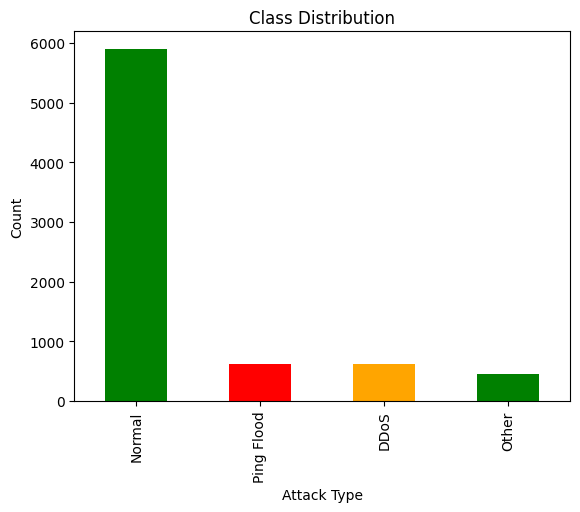

In [8]:
# Visualize the class distribution
data['attack_type'].value_counts().plot(kind='bar', color=['green', 'red', 'orange'], title='Class Distribution')
plt.xlabel('Attack Type')
plt.ylabel('Count')
plt.show()


In [9]:
# Check for missing values
print("Missing values in each column:")
print(data.isnull().sum())


Missing values in each column:
timestamp            0
source_ip            0
destination_ip       0
source_port          0
destination_port     0
protocol             0
packet_size          0
duration             0
num_packets          0
num_bytes            0
response_time        0
anomaly_score        0
connection_state     0
dns_requests         0
http_requests        0
data_exfiltration    0
attack_type          0
dtype: int64


In [10]:
# Drop rows with missing values (or alternatively, fill them)
data = data.dropna()
print("After dropping missing values, the new dataset size is:", data.shape)


After dropping missing values, the new dataset size is: (7581, 17)


In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'attack_type' column
encoder = LabelEncoder()
data['attack_type'] = encoder.fit_transform(data['attack_type'])

# Show the mapping of attack types to numeric labels
label_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print("Attack type encoding:", label_mapping)


Attack type encoding: {'DDoS': 0, 'Normal': 1, 'Other': 2, 'Ping Flood': 3}


In [12]:
# Drop unnecessary columns and set the target
X = data.drop(['attack_type', 'timestamp', 'source_ip', 'destination_ip', 'protocol', 'connection_state'], axis=1)
y = data['attack_type']

# Display the remaining features
print("Remaining features after dropping unnecessary columns:")
print(X.columns)



Remaining features after dropping unnecessary columns:
Index(['source_port', 'destination_port', 'packet_size', 'duration',
       'num_packets', 'num_bytes', 'response_time', 'anomaly_score',
       'dns_requests', 'http_requests', 'data_exfiltration'],
      dtype='object')


In [13]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.78      1.00      0.88      1181
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00       123

    accuracy                           0.78      1517
   macro avg       0.19      0.25      0.22      1517
weighted avg       0.61      0.78      0.68      1517



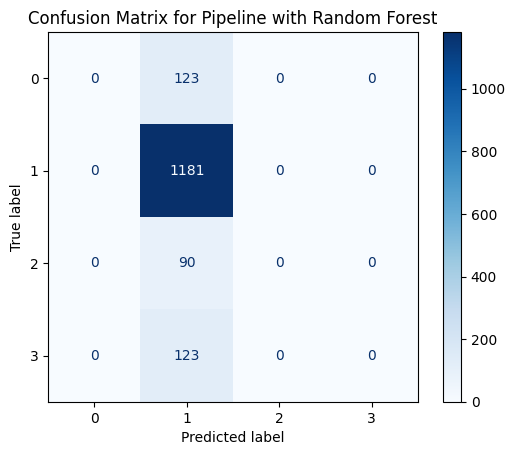

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Select numerical features (updated correctly after dropping unnecessary columns)
numerical_features = X_train.select_dtypes(exclude=['object']).columns

# Create a ColumnTransformer to scale only the numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features)
    ]
)

# Create a pipeline with the preprocessor and the Random Forest classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42))
])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Transform and predict on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Print classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot(cmap='Blues')
plt.title("Confusion Matrix for Pipeline with Random Forest")
plt.show()


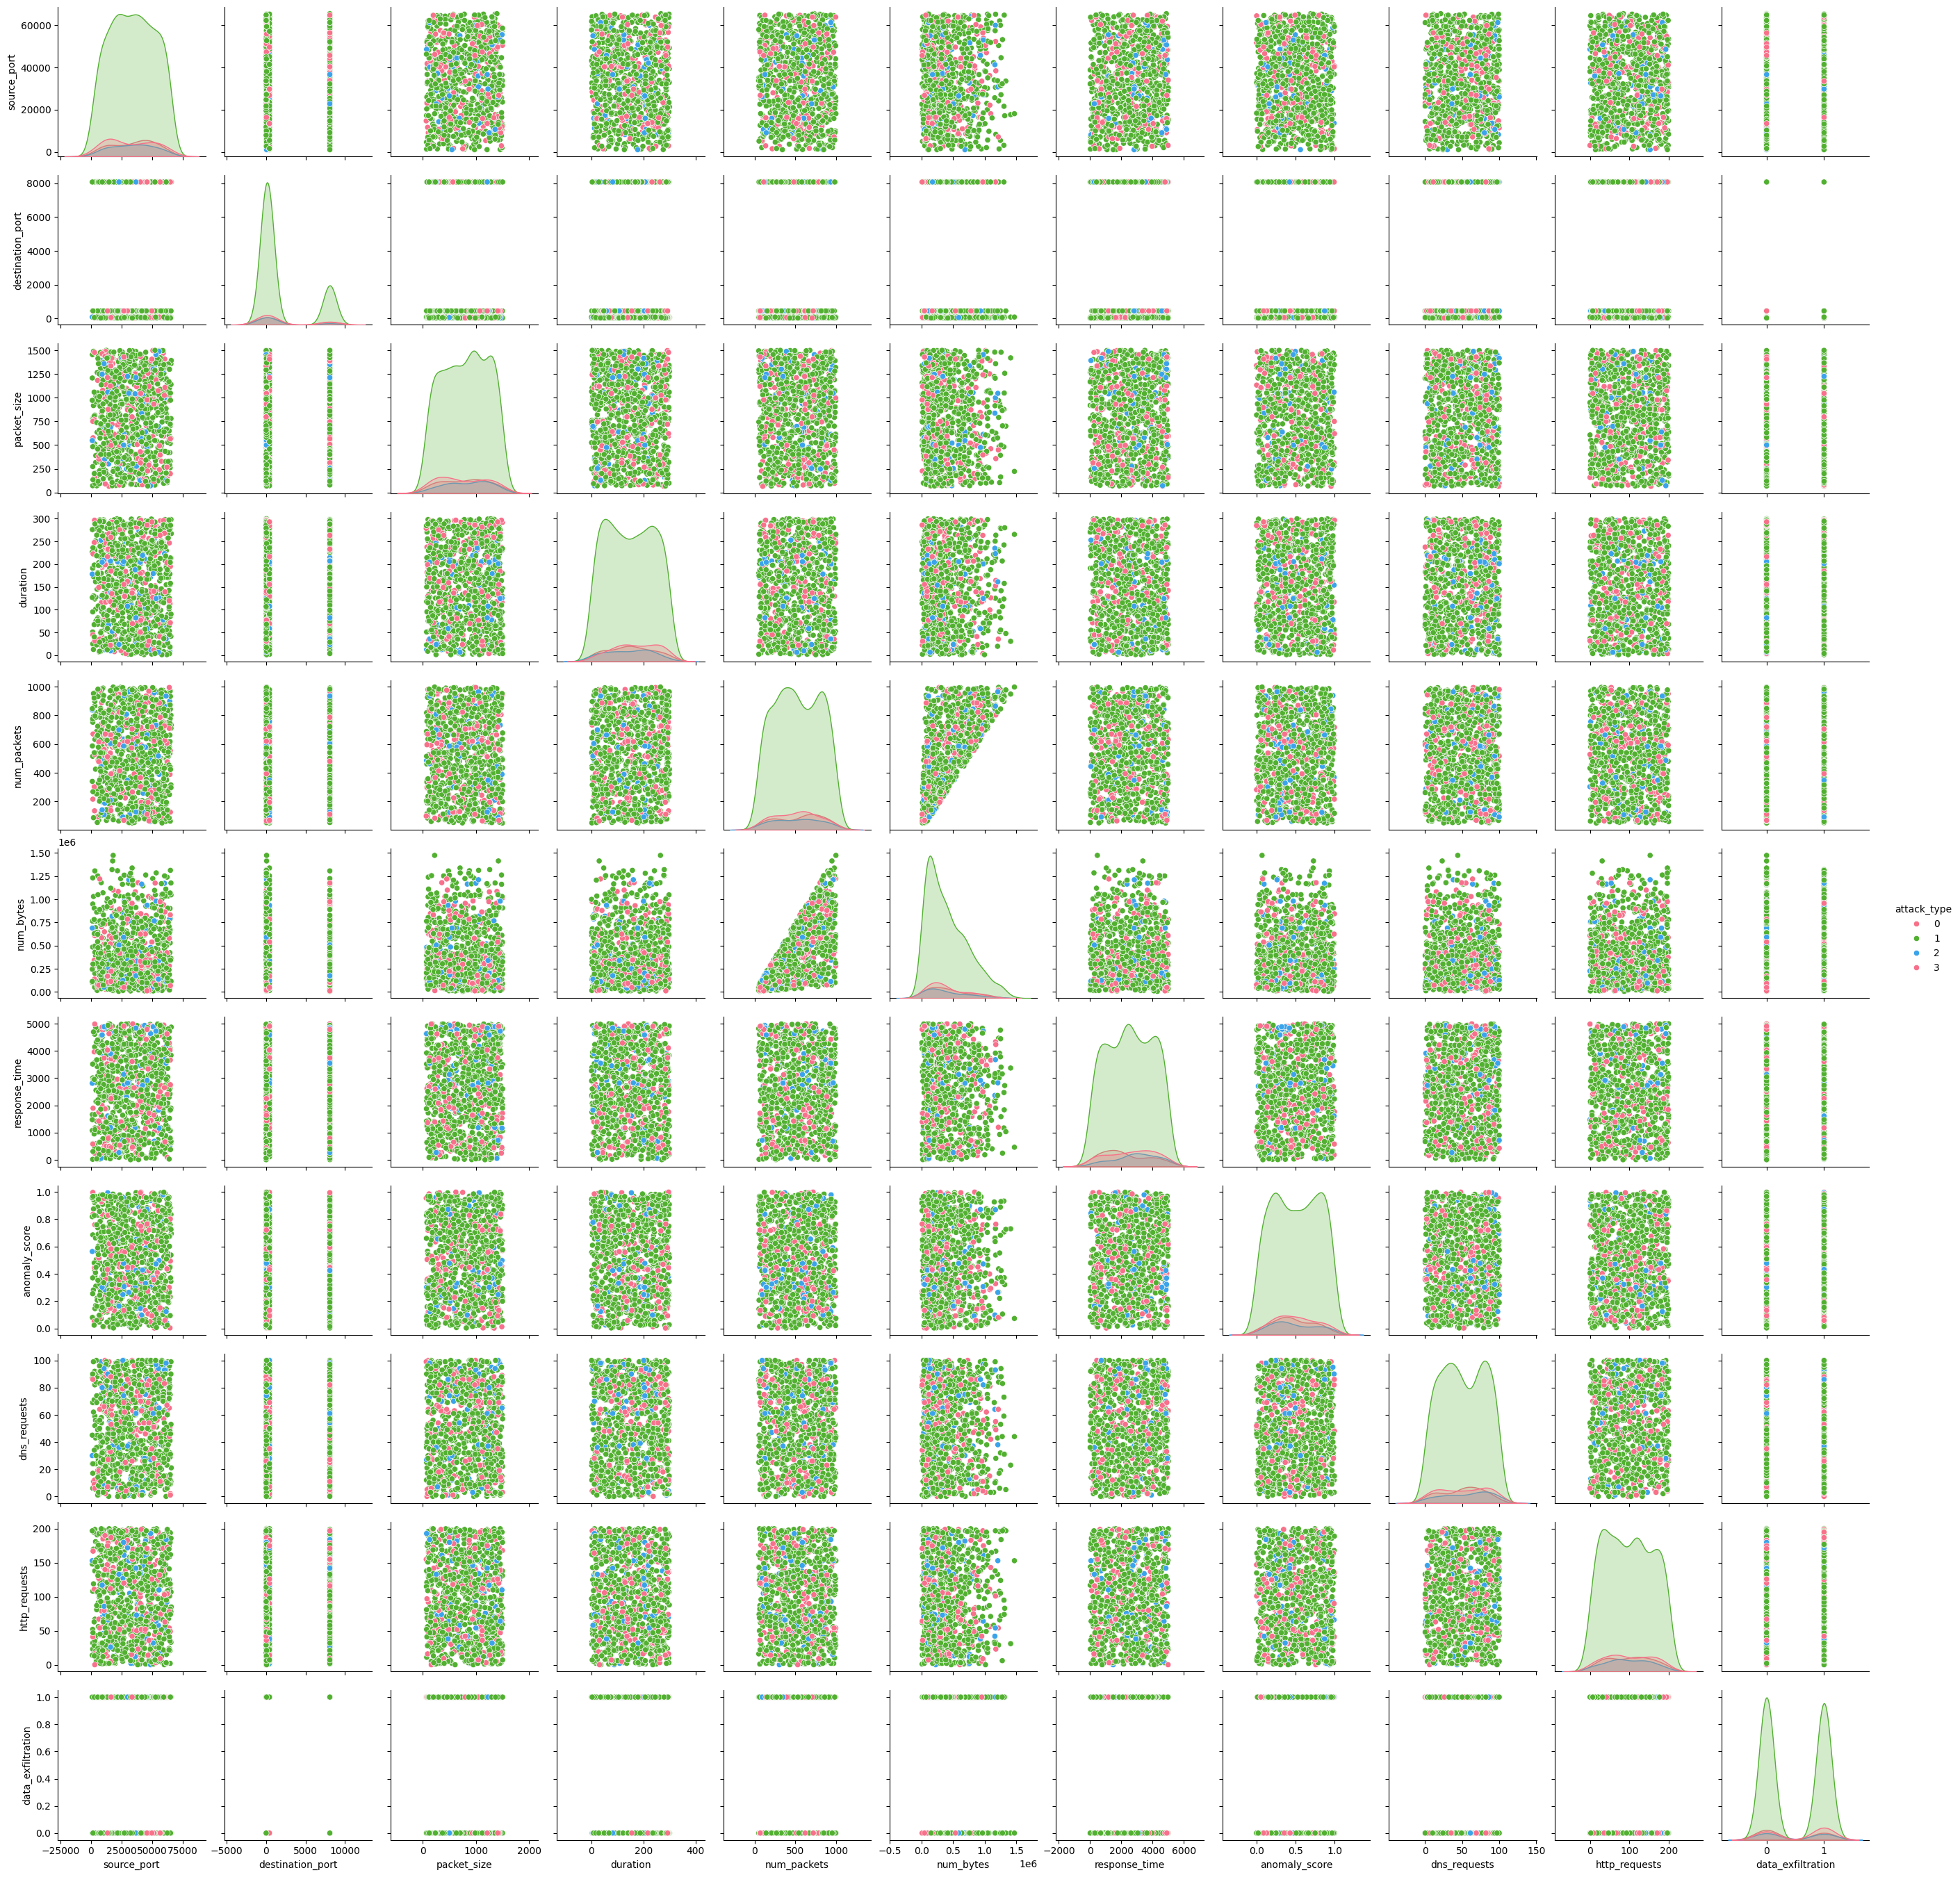

In [15]:
# Sample a subset to speed up visualization if dataset is too large
sampled_data = data.sample(1000)

# Visualize relationships between features and the target
sns.pairplot(sampled_data, hue='attack_type', diag_kind='kde', palette='husl')
plt.show()

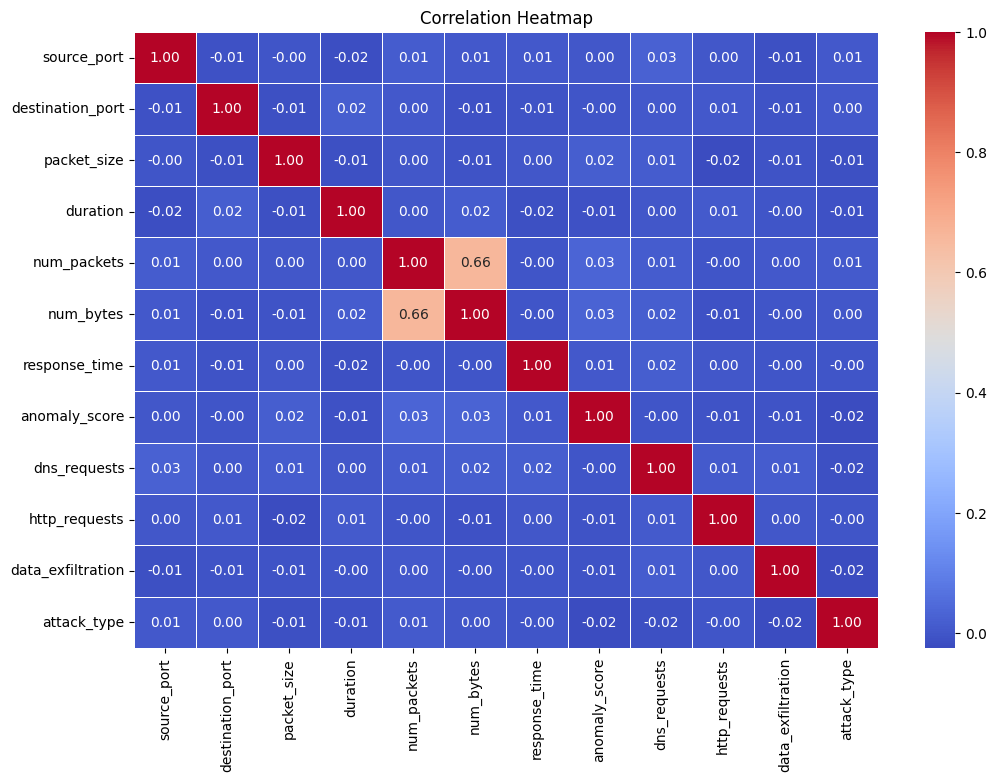

In [16]:
# Compute the correlation matrix
plt.figure(figsize=(12, 8))

# Exclude non-numeric columns before calculating correlation
numerical_data = data.select_dtypes(include=np.number)
correlation_matrix = numerical_data.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

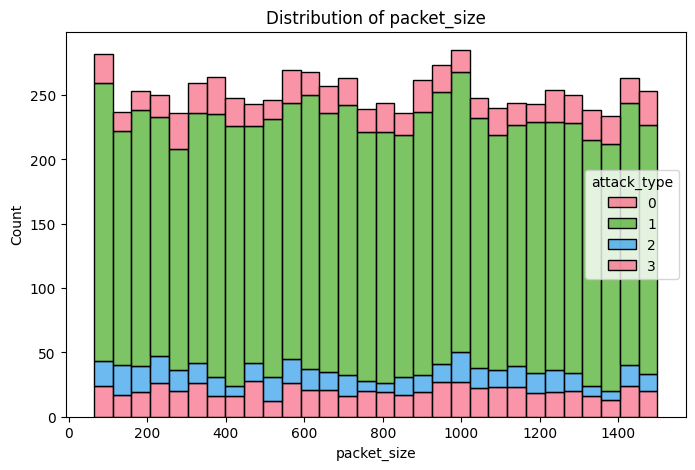

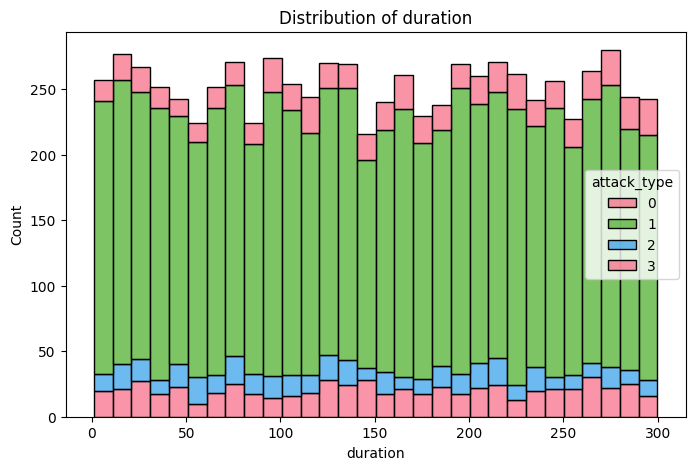

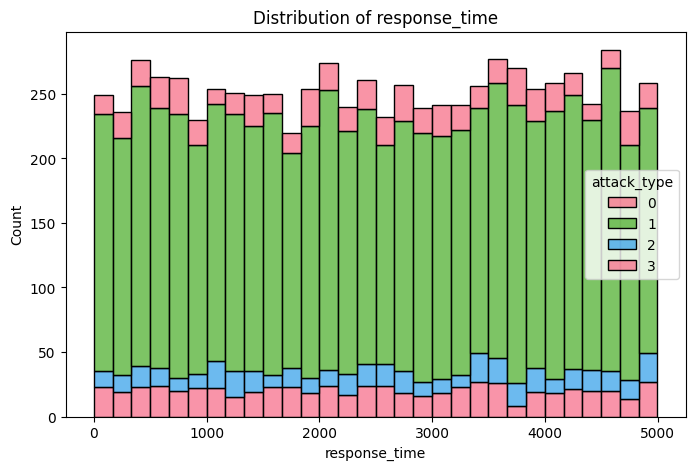

In [17]:
# Select numerical features to visualize
features_to_plot = ['packet_size', 'duration', 'response_time']

# Plot distributions
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.histplot(data, x=feature, hue='attack_type', multiple='stack', palette='husl', bins=30)
    plt.title(f'Distribution of {feature}')
    plt.show()


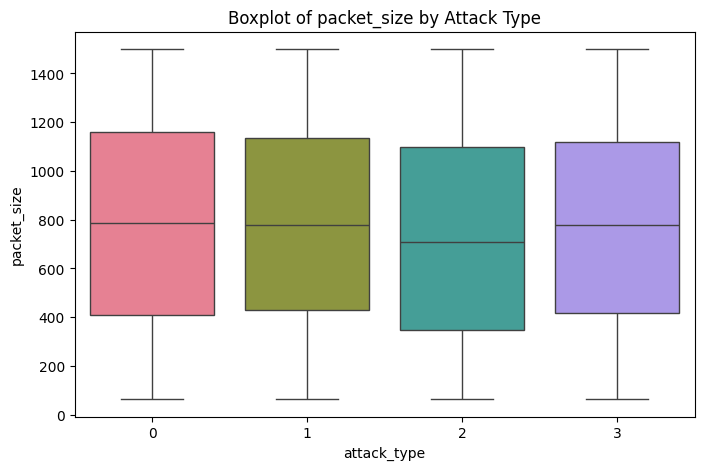

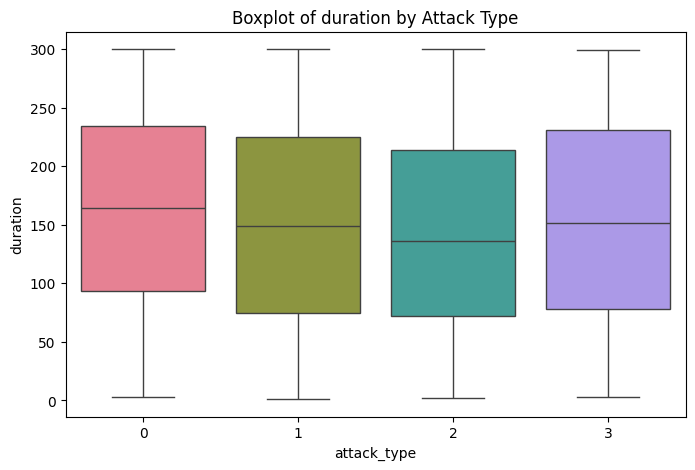

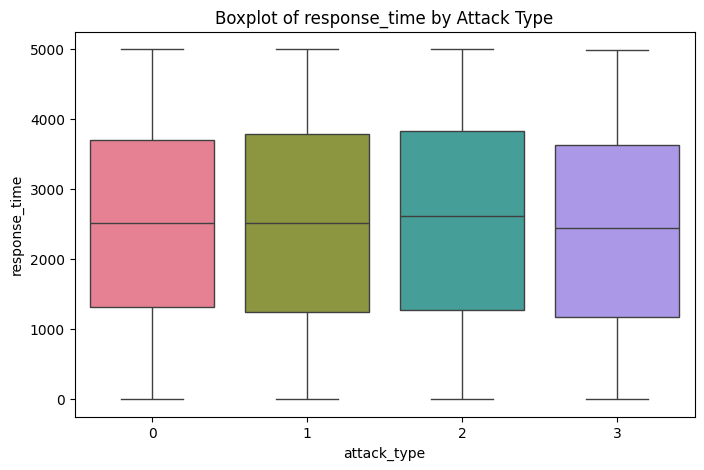

In [18]:
# Plot boxplots for selected features
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=data, x='attack_type', y=feature, palette='husl')
    plt.title(f'Boxplot of {feature} by Attack Type')
    plt.show()


In [19]:
# Initialize the classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)
print("Random Forest model trained successfully.")

# Make predictions
y_pred = rf_model.predict(X_test)


Random Forest model trained successfully.


In [20]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7779

Confusion Matrix:
[[   0  123    0    0]
 [   1 1180    0    0]
 [   0   90    0    0]
 [   0  123    0    0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.78      1.00      0.88      1181
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00       123

    accuracy                           0.78      1517
   macro avg       0.19      0.25      0.22      1517
weighted avg       0.61      0.78      0.68      1517



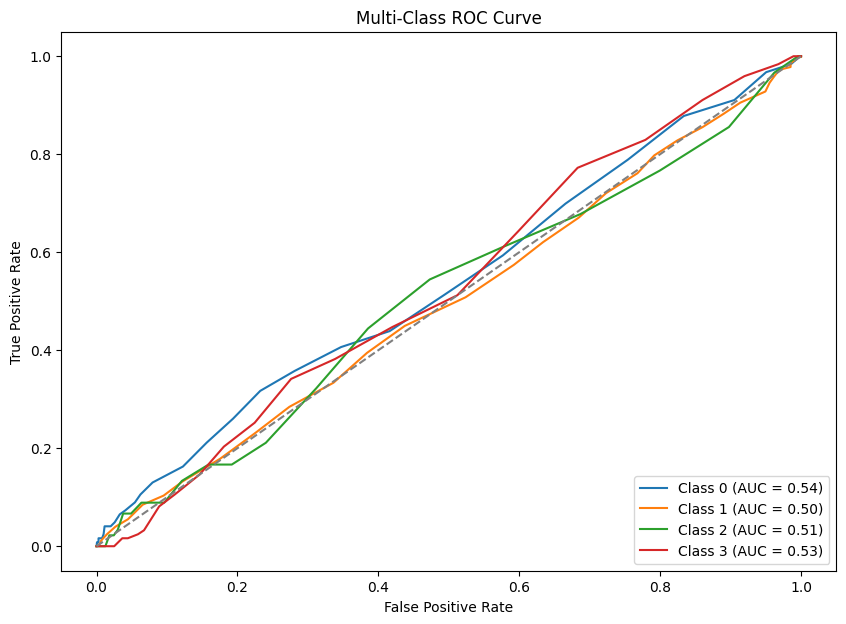

In [21]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Binarize the labels for multi-class ROC
y_train_binarized = label_binarize(y_train, classes=np.unique(y_train))
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_train_binarized.shape[1]

# Train One-vs-Rest classifier
rf_ovr = OneVsRestClassifier(RandomForestClassifier(random_state=42))
rf_ovr.fit(X_train, y_train_binarized)

# Get probability estimates for the test set
y_score = rf_ovr.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='grey')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [22]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_depth': [10, 20, 30, None],  # Max depth of trees
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum samples per leaf
}
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=3,  # 3-fold cross-validation
                           n_jobs=-1,  # Use all available processors
                           scoring='accuracy',  # Optimize for accuracy
                           verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Display the best parameters
print("Best parameters found: ", grid_search.best_params_)

# Train the optimized model
best_rf_model = RandomForestClassifier(**grid_search.best_params_, random_state=42)
best_rf_model.fit(X_train, y_train)

print("Optimized Random Forest model trained successfully.")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters found:  {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Optimized Random Forest model trained successfully.


In [23]:
# Make predictions
y_pred_optimized = best_rf_model.predict(X_test)

# Accuracy, confusion matrix, and classification report
print("\nAccuracy:", accuracy_score(y_test, y_pred_optimized))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_optimized))
print("\nClassification Report:\n", classification_report(y_test, y_pred_optimized))


Accuracy: 0.7778510217534608

Confusion Matrix:
 [[   0  123    0    0]
 [   1 1180    0    0]
 [   0   90    0    0]
 [   0  123    0    0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       123
           1       0.78      1.00      0.88      1181
           2       0.00      0.00      0.00        90
           3       0.00      0.00      0.00       123

    accuracy                           0.78      1517
   macro avg       0.19      0.25      0.22      1517
weighted avg       0.61      0.78      0.68      1517



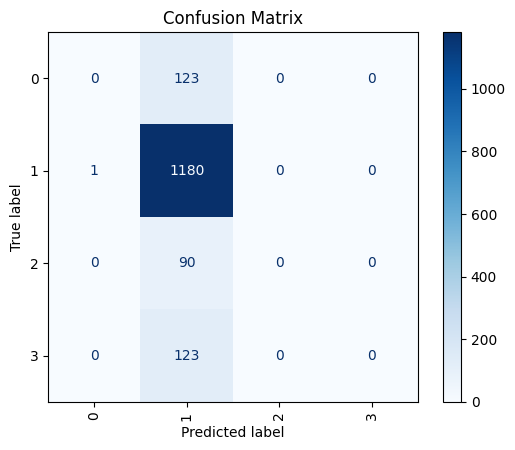

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_optimized = best_rf_model.predict(X_test)

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_optimized)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf_model.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()


In [25]:
# Drop irrelevant features before the pipeline, when X_train is still a DataFrame
X = data.drop(['attack_type', 'timestamp', 'source_ip', 'destination_ip', 'protocol', 'connection_state'], axis=1)
y = data['attack_type']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ... (Rest of your pipeline code) ...

# Now you can retrain the model without needing X_corrected
best_rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
best_rf_model.fit(X_train, y_train)

# Re-evaluate feature importances
importances_df = pd.DataFrame({
    'Feature': X.columns,  # Use the original DataFrame's columns
    'Importance': best_rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)



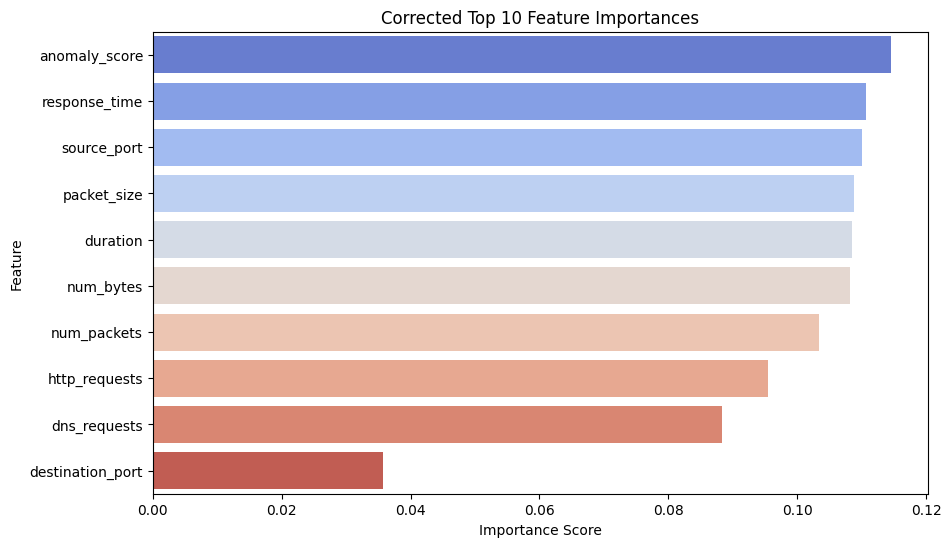

Feature  Importance
7     anomaly_score    0.114542
6     response_time    0.110695
0       source_port    0.110028
2       packet_size    0.108767
3          duration    0.108434
5         num_bytes    0.108162
4       num_packets    0.103313
9     http_requests    0.095467
8      dns_requests    0.088397
1  destination_port    0.035763

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df.head(10), palette='coolwarm')
plt.title('Corrected Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Display the top 10 features
importances_df.head(10)

In [27]:
import joblib
from sklearn.preprocessing import StandardScaler

# Step 1: Fit the scaler to your training data (if you haven't already)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Retrain Random Forest using the scaled data (if necessary)
best_rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42)
best_rf_model.fit(X_train_scaled, y_train)

# Step 2: Save the Random Forest model and the scaler
joblib.dump(best_rf_model, 'random_forest_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

print("Model and scaler saved successfully!")


Model and scaler saved successfully!
